# 1.Problem Defination

#### Problem
Our agency helps customers to purchase product XoX from various makers in the past.\
However, price estimations varied 
significantly with employees' experience. 

A few drawbacks associated with previous practices are described as below:\
    Lack of consistency: Different price estimation from different employees.\
    Human errors contributes significantly to the variation of predicted price.\
    Labor, time and cost: significant amount of resources allocated to the task.
#### Feature Engineering
Numeric data been transformed to float type and drop feature which do not has significent effect on price.\
Category data been transformed to numeric data by using LabelEncode and One-Hot Dummy method
#### Metric
mean_absolute_error, mean_squared_error, r2_score to validate the performence of model
#### Model 
LinearRegression, RandomForest Regression, XGBoost. Tune the models and choose the best model.

# 2. Raw Data Profile

In [1]:
# import libraries 

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
 

import matplotlib.pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



In [2]:
# read raw data and show raw data profile

location = r'C:\Users\86138\Desktop\Techlent\week5\sales.csv'
raw_df = pd.read_csv(location)
raw_df.head()


,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [3]:
raw_df[raw_df.maker=='M14123']

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm


the above code is because the test data could not run from the model because M14123 is only one in the whole data set. So the model learned from the train data, which there is no M14123, so could not predict.

In [4]:
raw_df.info()
raw_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           2216 non-null   object
 1   price          3186 non-null   object
 2   weight         3193 non-null   object
 3   purchase_date  3196 non-null   object
 4   product_type   3196 non-null   object
 5   product_level  3196 non-null   object
 6   maker          2373 non-null   object
 7   ingredient     2941 non-null   object
 8   height         3197 non-null   object
 9   width          3193 non-null   object
 10  depth          3193 non-null   object
dtypes: object(11)
memory usage: 274.9+ KB


,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
count,2216,3186,3193,3196,3196,3196,2373,2941,3197,3193,3193
unique,185,3157,119,1278,64,5,882,2833,161,41,13
top,$66k,"$20,061",3 Ton 0 Kg,Oct 05 2001,D,advanced,M14196,IN732638,2.54 meters,99 cm,26 cm
freq,104,2,127,8,485,1323,17,8,63,268,903


In [5]:
# Missing data 

temp_null=raw_df.isnull().sum()
total=raw_df.isnull().count()
percent=temp_null/total
missing_data=pd.concat([temp_null,percent],axis=1,keys=['temp_null','percent'])
missing_data

,temp_null,percent
cost,981,0.306850
price,11,0.003441
weight,4,0.001251
purchase_date,1,0.000313
product_type,1,0.000313
product_level,1,0.000313
maker,824,0.257742
ingredient,256,0.080075
height,0,0.000000
width,4,0.001251


   #### target: price

        numerical features: cost, weight, height, width, depth
        categorical features:product-type, product_level, maker, ingredient
        datetime:purchase_date

   #### Missing data:

        cost: 30.6% need transform to mean
        maker: 25.8% need transform to 'unknown_maker'
        ingredient: 8% need transform to 'unknown_ingredient'
    
    others are less than 1% could be replaced by mean() or droped. 

#### raw data profile by graph

In [6]:
df=raw_df.dropna(subset=['price']).reset_index(drop=True)

In [7]:
def price2num(x):
    if isinstance(x, str):
        x = x.strip("$").replace(",","")
    return float(x)

price = df.price.apply(price2num)

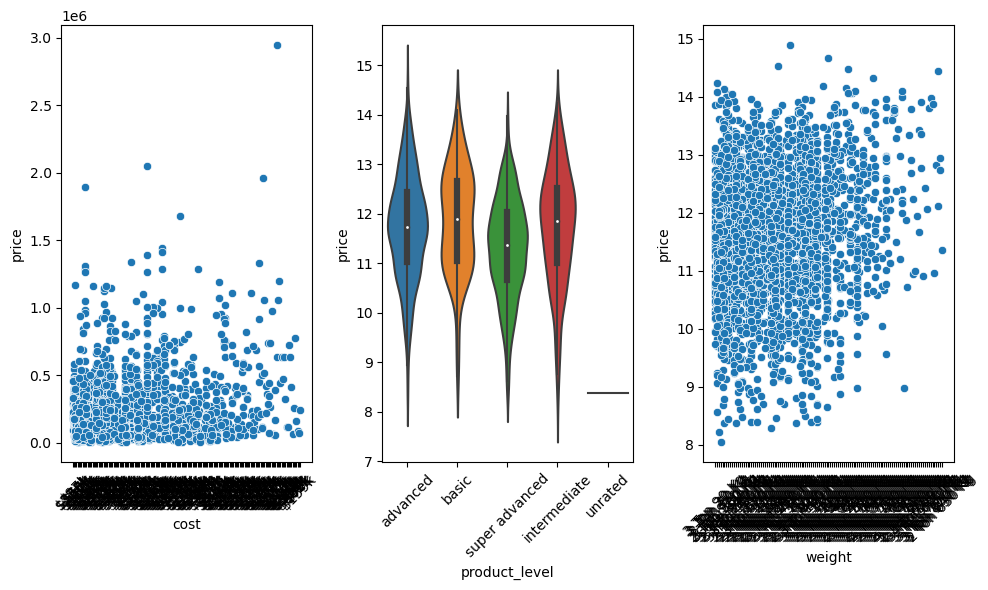

In [8]:
plt.figure(figsize = (10,6), dpi = 100)

df_weight_price = pd.concat([df.weight, price], axis=1)
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_weight_price, x='weight', y=df_weight_price.price.map(np.log))
plt.xticks(rotation = 45)

plt.subplot(1, 3, 2)
df_plevel_price = pd.concat([df.product_level, price], axis=1)
sns.violinplot(data=df_plevel_price, x='product_level', y=df_plevel_price.price.map(np.log))
plt.xticks(rotation = 45)

plt.subplot(1, 3, 1)
df_cost_price = pd.concat([df.cost, price], axis=1)
sns.scatterplot(data=df_cost_price, x='cost', y=df_cost_price.price)
plt.xticks(rotation = 45)
                
plt.tight_layout()
plt.show()

<AxesSubplot:>

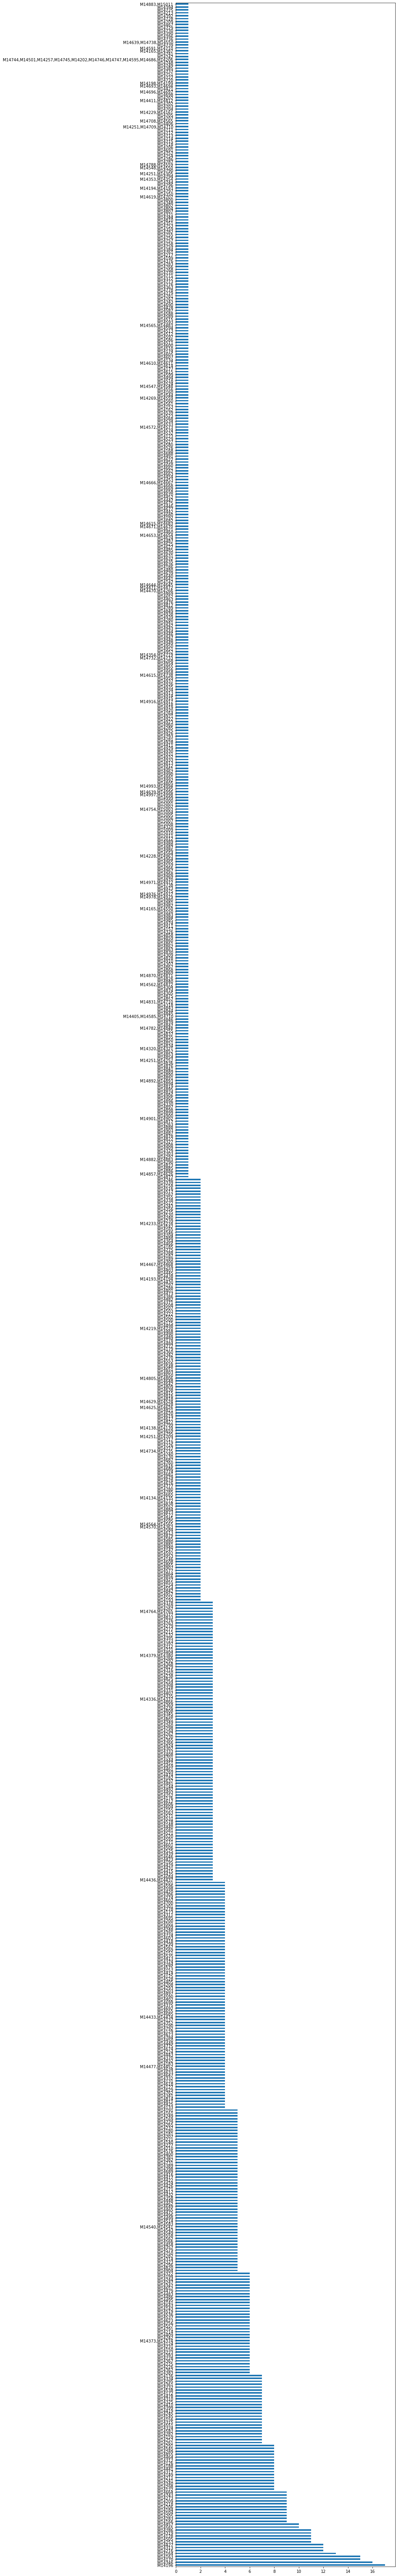

In [9]:
df.maker.value_counts().plot(kind='barh', figsize = (10,120))

<AxesSubplot:ylabel='product_type'>

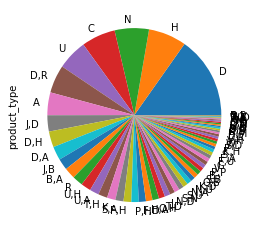

In [10]:
df.product_type.value_counts().plot(kind='pie')

In [11]:
df.ingredient.value_counts()

IN732638                                                                            8
IN732362                                                                            6
IN732200                                                                            4
IN732859                                                                            4
IN732832                                                                            4
                                                                                   ..
IN733467,IN732523,IN733468                                                          1
IN732393,IN732893,IN732282                                                          1
IN732776,IN732531                                                                   1
IN732613,IN733132                                                                   1
IN733462,IN732654,IN732149,IN733067,IN734088,IN733474,IN732868,IN732266,IN732193    1
Name: ingredient, Length: 2824, dtype: int64

In [12]:
len(df.ingredient.unique())

2825

In [13]:
def show_time_stationary(time, price):
    plt.scatter(time, price, alpha=0.6)
    x = df['purchase_date']
    y = df['price']
    plt.xlabel('time')
    plt.ylabel('price')
    
    plt.show()

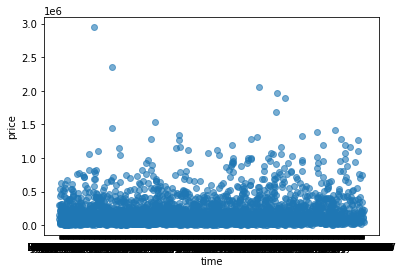

In [14]:
show_time_stationary(df['purchase_date'], price)

# 3. Feature Engineering

    create or decrease features improve model performance


In [15]:
# drop target null data
df=raw_df.dropna(subset=['price']).reset_index(drop=True)
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


### 3.1 Numeric data

In [16]:
# preprocessing numeric data

# transform numberic data to float type
df['price'] = df['price'].map(lambda x: x if type(x)==float 
                                          else float(x.strip('$').replace(',','')))
df['cost'] = df['cost'].map(lambda x: x if type(x)==float 
                                        else 1000*float(x.strip('$').strip('k')))
df['height'] = df['height'].map(lambda x: x if type(x)==float 
                                            else 100*float(x.strip('meters')))
df['width'] = df['width'].map(lambda x: x if type(x)==float 
                                          else float(x.strip('cm')))
df['depth'] = df['depth'].map(lambda x: x if type(x)==float 
                                          else float(x.strip('cm')))
df['weight'] = df['weight'].map(lambda x :x if type(x)==float 
                                            else float(x.strip('Kg').split('Ton')[0])
                                                 +0.001*float(x.strip('Kg').split('Ton')[1]))


# transform purchase_date to day month year 
df["purchase_date"] = pd.to_datetime(df["purchase_date"])
df['year'] = df['purchase_date'].dt.year.astype(float)
df['month'] = df['purchase_date'].dt.month.astype(float)
df['day'] = df['purchase_date'].dt.day.astype(float)

df['sin_month'] = df['month'].map(lambda x: np.sin(2*np.pi*x/12))
df['cos_month'] = df['month'].map(lambda x: np.cos(2*np.pi*x/12))
df['sin_day'] = df['day'].map(lambda x: np.sin(2*np.pi*x/30))
df['cos_day'] = df['day'].map(lambda x: np.cos(2*np.pi*x/30))

df1 = pd.DataFrame(df,columns = ['price','cost','height','width','depth','weight',
                                'year','sin_month','cos_month','sin_day','cos_day'])
df1.head()


,price,cost,height,width,depth,weight,year,sin_month,cos_month,sin_day,cos_day
0,300492.0,333000.0,276.0,97.0,26.0,3.09,2008.0,-2.449294e-16,1.000000e+00,-0.743145,-0.669131
1,430570.0,NaN,267.0,98.0,26.0,3.03,1997.0,-1.000000e+00,-1.836970e-16,0.866025,-0.500000
2,213070.0,270000.0,300.0,93.0,24.0,3.04,2001.0,-1.000000e+00,-1.836970e-16,0.866025,0.500000
3,229174.0,NaN,250.0,102.0,27.0,3.05,2016.0,-2.449294e-16,1.000000e+00,-0.994522,0.104528
4,122659.0,97000.0,247.0,101.0,26.0,2.97,2000.0,5.000000e-01,8.660254e-01,0.587785,-0.809017


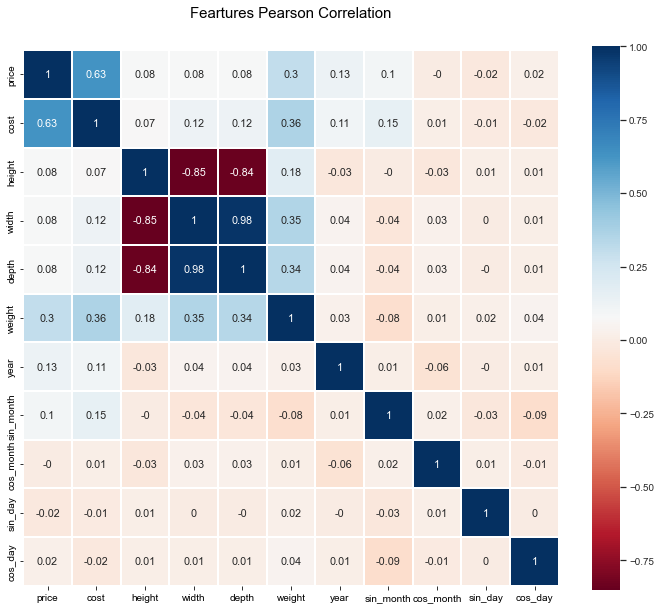

In [17]:
#analysis feature Correlation
def pearson_corr(df):
    
    
    correlation = df.astype(float).corr(method='pearson')
    colormap = plt.cm.RdBu
    
    plt.figure(figsize=(12,10))
    plt.title('Feartures Pearson Correlation', y=1.05, size=15)
    sns.set(font_scale=0.9)
    sns.heatmap(round(correlation,2),linewidths=0.1,vmax=1.0, square=True,  
                cmap=colormap, linecolor='white', annot=True)
    plt.show()

pearson_corr(df1)
    


In [18]:
# use volume to replace height, width, depth which are highly correlated.

df1['volume'] = df1['height']*df1['width']*df1['depth']
df1 = df1.drop(columns=['height','width','depth'])


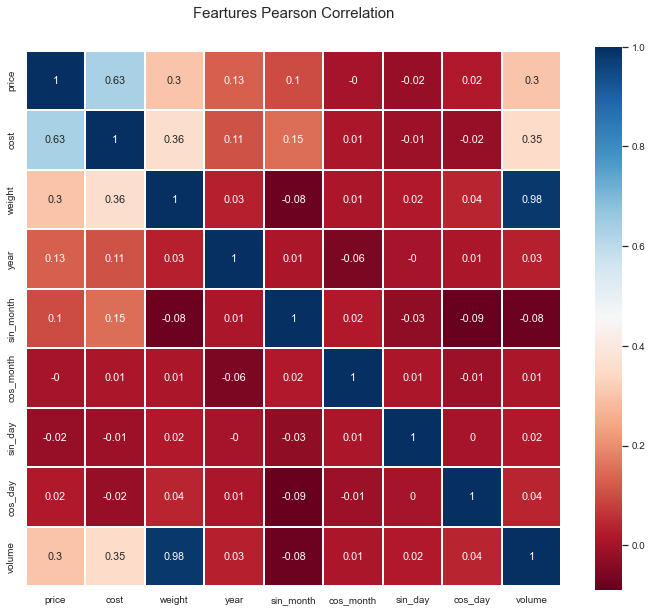

In [19]:
pearson_corr(df1)

#### volume dropped since highly correlated with weight, and volume is engineered data.

In [20]:
# volume dropped 
df1 = pd.DataFrame(df1,columns=['price','cost','weight'])
df1.head()

,price,cost,weight
0,300492.0,333000.0,3.09
1,430570.0,NaN,3.03
2,213070.0,270000.0,3.04
3,229174.0,NaN,3.05
4,122659.0,97000.0,2.97


### 3.2 Category Data

In [21]:
#preprocessing with category data

# fill null for category data with unknown_category
df['maker'] = df['maker'].fillna('unknown_maker')
df['ingredient'] = df['ingredient'].fillna('unknown_ingredient')
df['product_type'] = df['product_type'].fillna('unknown_product_type')


####  dropl maker, keep ingredient,  product_type, product_leve
               

### Feature engineering result: keep cost, weight, ingredient, product_type, product_level as the key features. 
Drop month, day, purchase_date, since their variance with price is too small\
Drop height, width, depth since they highly correlated with each other,\
Drop egnineered feature: volume which has collineary with weight. 
Drop maker because the unknow_maker has top frequence.

# 4. Modeling


    model selection, hyperparameters tunning,

In [22]:
#seperate the dataset into train and test
train_raw = df[df.year < 2015].reset_index(drop=True)  
test_raw  = df[df.year >= 2015].reset_index(drop=True)

In [23]:
# evaluate model by loss function

def loss_report(name, model, X_train, y_train, X_test, y_test, graph=1):
    
    
    def calculate_loss(model, X, y):
        pred = model.predict(X)
        mae = mean_absolute_error(y, pred)
        mse = mean_squared_error(y, pred)
        r2 = r2_score(y, pred)
        return pred, mae, mse, r2
    
    
    y_train_pred, mae_train, mse_train, r2_train = calculate_loss(model, X_train, y_train)
    y_test_pred, mae_test, mse_test, r2_test = calculate_loss(model, X_test, y_test)
    
    if graph == 0:
        return 

    elif graph == 1:
        plt.figure(figsize = (7,5), dpi = 100)
        plt.scatter(y_train, y_train_pred, s=15, alpha =0.3,label='train')
        plt.scatter(y_test, y_test_pred,s=15, alpha =0.3,label='test')
        plt.xlabel('True Price')
        plt.ylabel('Predicted Price')
        plt.legend(loc='best')
 
        plt.tight_layout()
        plt.show()
    
    print('Model performance for: ', name)
    
    print(f'training MAE: {mae_train:.2e}')
    print(f'training MSE: {mse_train:.2e}')
    print(f'training R2: {r2_train:.3f}')
    print()   
        
    print(f'testing MAE: {mae_test:.2e}')
    print(f'testing MSE: {mse_test:.2e}')
    print(f'testing R2: {r2_test:.3f}')


In [24]:
# transform numeric and category data

class Transformer(object):
    def __init__(self):
        self.mean = 0
     
    def fit(self, X, y=None): 
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['ingredient'] = X.ingredient.map(self.calculate)
        
        self.mean_cost = df.cost.mean()
        self.mean_weight = df.weight.mean()
        self.mean_ingredient = df.ingredient.mean()
        
        # for product_type
        self.pt_encode = X.product_type.value_counts()
                
        # for product_level (ordinal type)
        self.keys = set(X.product_level)
    
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num).fillna(self.mean_cost)
        df['weight'] = X.weight.map(self.weight2num).fillna(self.mean_weight)
        df['ingredient'] = X.ingredient.map(self.calculate).fillna(self.mean_ingredient)
                  
        #for product_type
        df['product_type'] = X.product_type.map(lambda x: self.pt_encode[x])
       
        #for product_level
        trans_res = {}
        rank = self.keys
        for i, item in enumerate(rank):
            trans_res[item] = i+1
        df['product_level'] = X.product_level.map(lambda x: trans_res[x])
        
        df3 = df[['cost','weight','ingredient','product_type','product_level']]
        return df3
        
 

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def cost2num(self, x):
        if type(x) == str: 
            x = float(x.strip('$').strip('k'))*1000
        return x
    
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip(' Kg') 
            x_list = x.split(' Ton ')
            x = float(x_list[0])+float(x_list[1])*0.001
        return x
    
    def calculate(self,x):
        if type(x) == str: 
            return len(x.split(','))

ct = Transformer()
ct.fit_transform(train_raw).head()
   

,cost,weight,ingredient,product_type,product_level
0,333000.000000,3.09,2,26,5
1,166184.183143,3.03,5,94,3
2,270000.000000,3.04,3,94,3
3,97000.000000,2.97,3,160,5
4,59000.000000,2.93,6,149,4


In [25]:
features = ['cost','weight','ingredient','product_type','product_level']
target = "price"


def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [26]:
#three model for compare: linear regression, random forest, XGBoost
steps_lr = [('clt',Transformer()),
           ('rescale', MinMaxScaler()),
           ('lr',LinearRegression())
           ]
model_lr = Pipeline(steps_lr)

steps_rf = [('clt',Transformer()),
           ('rescale', MinMaxScaler()),
           ('rf',RandomForestRegressor(random_state=1393))
           ]
model_rf = Pipeline(steps_rf)
          
steps_xgb = [('clt',Transformer()),
            ('rescale', MinMaxScaler()),
            ('xgb',XGBRegressor(random_state=1393))
            ]
model_xgb = Pipeline(steps_xgb)


In [27]:
model_rf.fit(X_train,y_train)


Pipeline(steps=[('clt', <__main__.Transformer object at 0x00000224F32BFAF0>),
                ('rescale', MinMaxScaler()),
                ('rf', RandomForestRegressor(random_state=1393))])

In [28]:
y_train_pred = model_rf.predict(X_train)

In [29]:
y_test_pred = model_rf.predict(X_test)

这里分开写是想验证下 Maker  test 数据里面有一个 值是咋IMAker 的 Train 数据里面没有的， 所以， Train 可以跑过， Test跑不过。

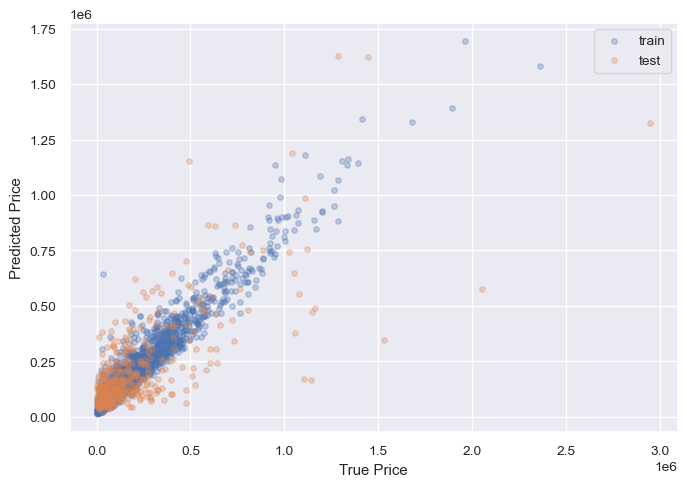

Model performance for:  RandomForest
training MAE: 3.87e+04
training MSE: 3.64e+09
training R2: 0.914

testing MAE: 1.18e+05
testing MSE: 4.12e+10
testing R2: 0.522


In [30]:
loss_report('RandomForest',model_rf, X_train, y_train, X_test, y_test, graph=1)

In [31]:
model_lr.fit(X_train,y_train)


Pipeline(steps=[('clt', <__main__.Transformer object at 0x00000224F32B6070>),
                ('rescale', MinMaxScaler()), ('lr', LinearRegression())])

In [32]:
model_xgb.fit(X_train,y_train)


Pipeline(steps=[('clt', <__main__.Transformer object at 0x00000224F32012B0>),
                ('rescale', MinMaxScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=1393, ...))])

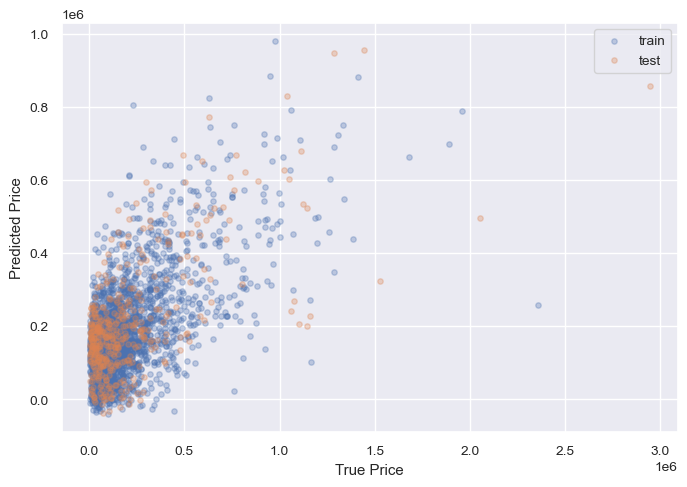

Model performance for:  LinearRegression
training MAE: 1.10e+05
training MSE: 2.67e+10
training R2: 0.374

testing MAE: 1.41e+05
testing MSE: 5.16e+10
testing R2: 0.401


In [33]:
loss_report('LinearRegression', model_lr, X_train, y_train, X_test, y_test, graph=1)

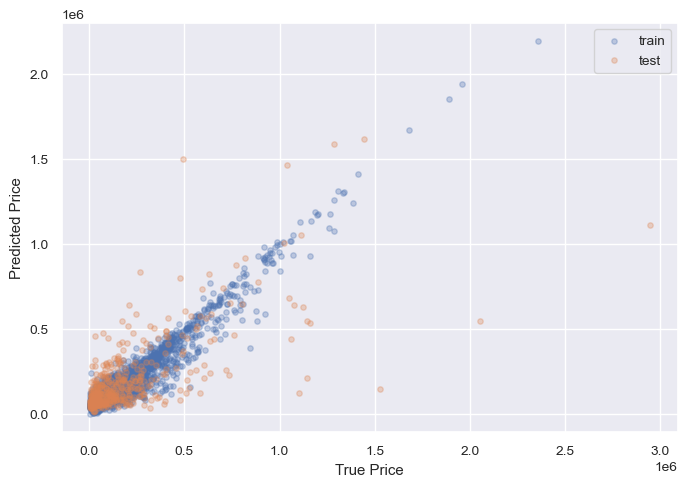

Model performance for:  XGBoost
training MAE: 4.15e+04
training MSE: 3.50e+09
training R2: 0.918

testing MAE: 1.20e+05
testing MSE: 4.63e+10
testing R2: 0.463


In [34]:
loss_report('XGBoost', model_xgb, X_train, y_train, X_test, y_test, graph=1)

### tune the hyperparameters to fix the overfit and increase R2

In [35]:
def search_best_estimators(steps, X, y, param_grid):
    model = Pipeline(steps)
    grid_search = GridSearchCV(model, 
                                param_grid, 
                                cv=5, 
                                verbose=True, 
                                n_jobs=-1,
                                scoring='neg_mean_squared_error'
                             )
    res = grid_search.fit(X, y)
    
    print(res.best_score_)
    print(res.best_params_)

In [36]:
param_grid_rf = {'rf__n_estimators': [40,50,60],
                  'rf__min_samples_split': [10,12,14,20],
                  'rf__min_samples_leaf': [2,4,6,8],
                  'rf__max_depth': [8,10,12,20],
                 }
steps_rf = [('ctf',Transformer()),
            ('rescale',MinMaxScaler()),
            ('rf',RandomForestRegressor(random_state=1393))
           ]

In [37]:
#search_best_estimators(steps_rf,X_train,y_train,param_grid_rf)

In [38]:
steps_rf_2 = [('ctf',Transformer()),
              ('rescale',MinMaxScaler()),
              ('rf',RandomForestRegressor(n_estimators=40, max_depth=8, min_samples_leaf=2,
               min_samples_split=10,random_state=1393))
             ]
model_rf_2 = Pipeline(steps_rf_2)

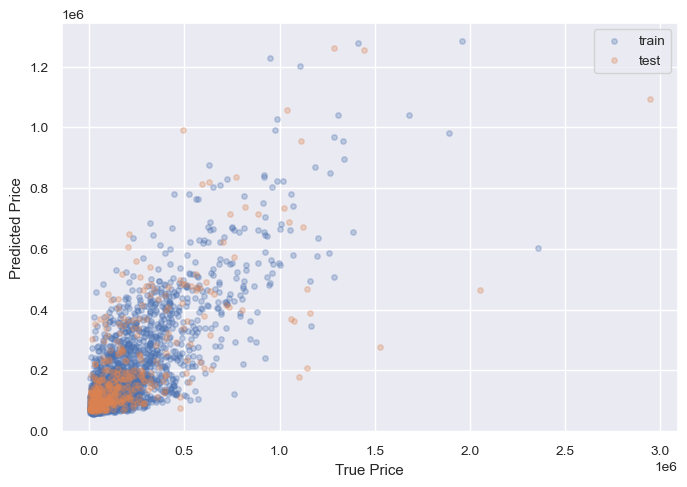

Model performance for:  RandomForest
training MAE: 8.49e+04
training MSE: 1.62e+10
training R2: 0.619

testing MAE: 1.15e+05
testing MSE: 4.30e+10
testing R2: 0.501


In [39]:
model_rf_2.fit(X_train,y_train)
loss_report('RandomForest',model_rf_2, X_train, y_train, X_test, y_test, graph=1)

In [40]:
param_grid_xgb = {'xgb__learning_rate':[0.1, 0.05],
                  'xgb__n_estimators':[80,90,100],
                  'xgb__max_depth':[2,4,6], 
                  'xgb__min_child_weight':[14,16,18], 
                  'xgb__gamma':[0,0.05,],
                  'xgb__subsample': [0.4, 0.5, 0.6],
                  'xgb__colsample_bytree': [0.7, 0.8,1.0]
                  }
steps_xgb = [('ctf',Transformer()),
            ('rescale',MinMaxScaler()),
            ('xgb',XGBRegressor(random_state=1393))
            ]

In [41]:
#search_best_estimators(steps_xgb,X_train,y_train,param_grid_xgb)

In [42]:
steps_xgb_2 = [('ctf',Transformer()),
               ('rescale',MinMaxScaler()),
               ('xgb',XGBRegressor(random_state = 1393, learning_rate = 0.1, n_estimators = 80,
                                    gamma = 0, subsmaple = 0.4, min_child_weight = 14, colsample_bytree = 0.7,
                                    max_depth = 2))
              ]
model_xgb_2 = Pipeline(steps_xgb_2)


[21:04:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "subsmaple" } are not used.



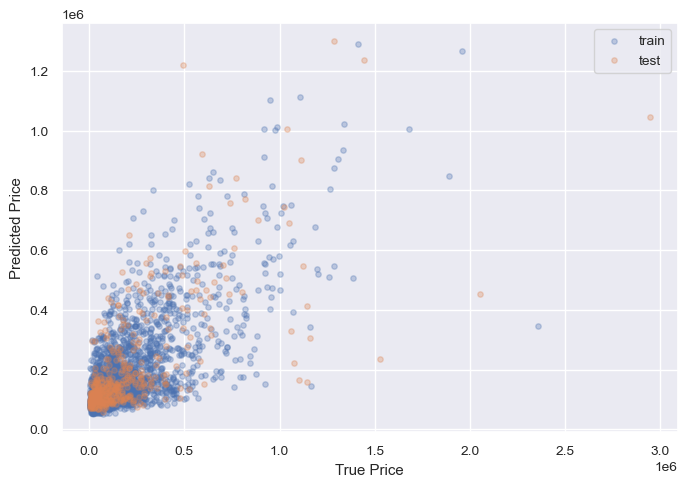

Model performance for:  XGBoost
training MAE: 9.52e+04
training MSE: 2.11e+10
training R2: 0.504

testing MAE: 1.19e+05
testing MSE: 4.60e+10
testing R2: 0.467


In [43]:
model_xgb_2.fit(X_train,y_train)
loss_report('XGBoost',model_xgb_2, X_train, y_train, X_test, y_test, graph=1)

#### feature importance 
show feature importance by RandomForest of model_rf_2

<BarContainer object of 5 artists>

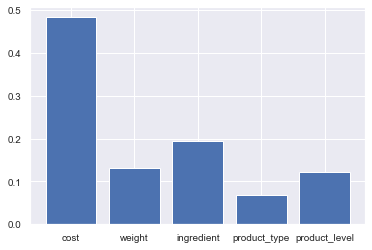

In [44]:
plt.bar(['cost', 'weight', 'ingredient','product_type','product_level'],model_xgb_2[2].feature_importances_)

# 5. Result Analysis and Further Discussion  

#### The best performance model is the following model from RandomForest
    steps_rf_2 = [('ctf',Transformer()),
                  ('rescale',MinMaxScaler()),
                  ('rf',RandomForestRegressor(n_estimators=60, max_depth=8, min_samples_leaf=6,
                  min_samples_split=10,random_state=1393))
                 ]


XGBoost has very close performance.
    

 ### Discussion:
 
    Cost is most important feature, but has biggest missing part, filling the missing data with whole cost data's mean 
    in order to cover the data profile. Should have better way to fill NA such as KNN method to generate the missing cost data.
       
    Train and test split invoved year 2015, according to time series prediction, it is the best practice way to predict. 
     
       

### Summary:
    
    A RandomForest model has been chosen to predict price based on the features given.
    A much improved consistency on price estimation: model predict price base on data and algorithm. No human errors in the 
    process. 
    
    Self imporvement: Model can be validated and adjusted. Data accumulated can help to tune the model consistently for 
    potentially more accurate prediction.
    
    Also company saved thousands dollars on training new employees, as well as the costs came from new employee's 
    mistakes which could lost customers.
    
    On the other hand, with ML model involved, new employee will fit on the job quickly, smooth the process and keep 
    customer happy too. 
    
    
    
    
    